Gabor ML - Problem 16

# Libraries

In [26]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt

# Functions

In [27]:
#function that creates x and y data
def generate_xy(n, d):
    # create covariance matrix
    cov = np.identity(d)    
    for i in range(d):
        cov[i,i] = 1/(i+1)
    # create x sample data
    x = np.random.multivariate_normal(np.zeros(d), cov, n)
    # initialize y data
    y = np.zeros(n)
    # standard normal error
    e = np.random.normal(0, 1, n)
    # determine y values by x values
    for i in range(n):
        y[i] = sum(x[i]) + e[i]
    return x, y

#function that gives parameters from OLS
def algorithm_OLS(x, y):
    #get n and d from x
    n = len(x)
    d = len(x[0])
    #follow the math from the hw description
    temp_matrix = np.zeros((d,d))
    for i in range(n):
        add_matrix = np.outer(x[i], x[i].T)
        temp_matrix = np.add(temp_matrix, add_matrix)
    temp_matrix = np.multiply(1/n, temp_matrix)
    temp_matrix = np.linalg.inv(temp_matrix)
    #follow the math from the hw description
    temp_vec = np.zeros(d)
    for i in range(n):
        add_vec = np.multiply(x[i], y[i])
        temp_vec = np.add(temp_vec, add_vec)
    temp_vec = np.multiply(1/n, temp_vec)
    #return w parameter
    w = np.dot(temp_matrix, temp_vec)
    return w

#function that gives parameters using GD - gradient descent
def algorithm_GD(x, y, method_learning_rate):
    #get n and d from x    
    n = len(x)
    d = len(x[0])
    #create a list of what the learning rate will be at step_t
    if method_learning_rate == "fixed":
        step_at_t = [.1 for i in range(n)]
    else:
        step_at_t = [1/np.sqrt(i+1) for i in range(n)]

    #create a matrix of parameters at each step
    w = np.zeros((n,d))
    #with an initial vector
    w_0 = np.zeros(d)

    #determine parameters for each step
    for t in range(n):
        temp_vec_sum = np.zeros(d)
        #if we're at the first step, we'll use a zero vector as the initial parameter values
        if t == 0:
            for i in range(n):
                temp1 = np.multiply(np.dot(w_0.T,x[i]),x[i])
                temp2 = np.multiply(x[i], y[i])
                temp3 = np.subtract(temp1, temp2)
                temp_vec_sum = np.add(temp_vec_sum, temp3)
            temp_vec_sum = np.multiply(step_at_t[t],temp_vec_sum)
            temp_vec_sum = np.multiply(2/n,temp_vec_sum)
            w[t] = np.subtract(w_0, temp_vec_sum)
        else:
            for i in range(n):
                temp1 = np.multiply(np.dot(w[t-1].T,x[i]),x[i])
                temp2 = np.multiply(x[i], y[i])
                temp3 = np.subtract(temp1, temp2)
                temp_vec_sum = np.add(temp_vec_sum, temp3)
            temp_vec_sum = np.multiply(step_at_t[t],temp_vec_sum)
            temp_vec_sum = np.multiply(2/n,temp_vec_sum)
            w[t] = np.subtract(w[t-1], temp_vec_sum)

    #calculate average of parameters
    w_average = np.zeros(d)
    for t in range(n):
        w_average = np.add(w_average, w[t])
    w_average = np.multiply(1/n, w_average)
    return w_average

#function that gives parameters using GD - gradient descent
def algorithm_SGD(x, y, method_learning_rate):
    #get n and d from x    
    n = len(x)
    d = len(x[0])
    #create a list of what the learning rate will be at step_t
    if method_learning_rate == "fixed":
        step_at_t = [.1 for i in range(n)]
    else:
        step_at_t = [1/np.sqrt(i+1) for i in range(n)]

    #create a matrix of parameters at each step
    w = np.zeros((n,d))
    #with an initial vector
    w_0 = np.zeros(d)

    #determine parameters for each step
    for t in range(n):
        #if we're at the first step, we'll use a zero vector as the initial parameter values
        if t == 0:
            temp1 = np.multiply(np.dot(w_0.T,x[t]),x[t])
            temp2 = np.multiply(x[t], y[t])
            temp_vec = np.subtract(temp1, temp2)
            temp_vec = np.multiply(2,temp_vec)
            temp_vec = np.multiply(step_at_t[t],temp_vec)
            w[t] = np.subtract(w_0, temp_vec)
        else:
            temp_vec = np.subtract(np.multiply(np.dot(w[t-1].T,x[t]),x[t]), np.multiply(x[t], y[t]))
            temp_vec = np.multiply(2,temp_vec)
            temp_vec = np.multiply(step_at_t[t],temp_vec)
            w[t] = np.subtract(w[t-1], temp_vec)

    #calculate average of parameters
    w_average = np.zeros(d)
    for t in range(n):
        w_average = np.add(w_average, w[t])
    w_average = np.multiply(1/n, w_average)
    return w_average

#function that calculates the MSE
def mean_square_error(x, y, w):
    #get n and d from x    
    n = len(x)
    #initialize
    mse = 0
    for i in range(n):
        mse += np.square(np.dot(w.T,x[i])-y[i])
    mse = mse/n
    return mse


# Compare OLS, Gradient Descent, Stocastic Gradient Descent with fixed learning Rate

## Calculate metrics for OLS, GradDesc, StoGradDesc

In [28]:
#Determine algorithm performance when learning rate is fixed.

results_fixed = pd.DataFrame()
method_learning_rate = "fixed"
method_algorithm = ['OLS','GradDesc','StoGradDesc']
n_values = [10, 20, 100, 500]
d_values = [2, 5, 10, 50, 100]

#calculate average of the performance results over 5 runs
number_of_runs = 5
run_number = 0

#running through the n_values and d_values to compare algorithm methods
while run_number < number_of_runs:
    print(run_number)
    for n in n_values:
        for d in d_values:
            arr_train_x, arr_y_train = generate_xy(n, d)
            arr_test_x, arr_y_test = generate_xy(n, d)
            for method in method_algorithm:
                start = time.time()
                if method == 'OLS':
                    w = algorithm_OLS(arr_train_x, arr_y_train)
                elif method == 'GradDesc':
                    w = algorithm_GD(arr_train_x, arr_y_train, method_learning_rate)
                else:
                    w = algorithm_SGD(arr_train_x, arr_y_train, method_learning_rate)
                end = time.time()
                mse_train = mean_square_error(arr_train_x, arr_y_train, w)
                mse_test = mean_square_error(arr_test_x, arr_y_test, w)
                run_time = (end - start)
                line_ = pd.DataFrame([[method, n, d, run_time, mse_train, mse_test]], columns = ['method','n_value','d_value','run_time','mse_train','mse_test'])
                results_fixed = pd.concat([results_fixed, line_], ignore_index = True)
                results_fixed.reset_index(drop = True, inplace = True)
    run_number += 1


0
1
2
3
4


## Compare method by sample size - fixed learning rate

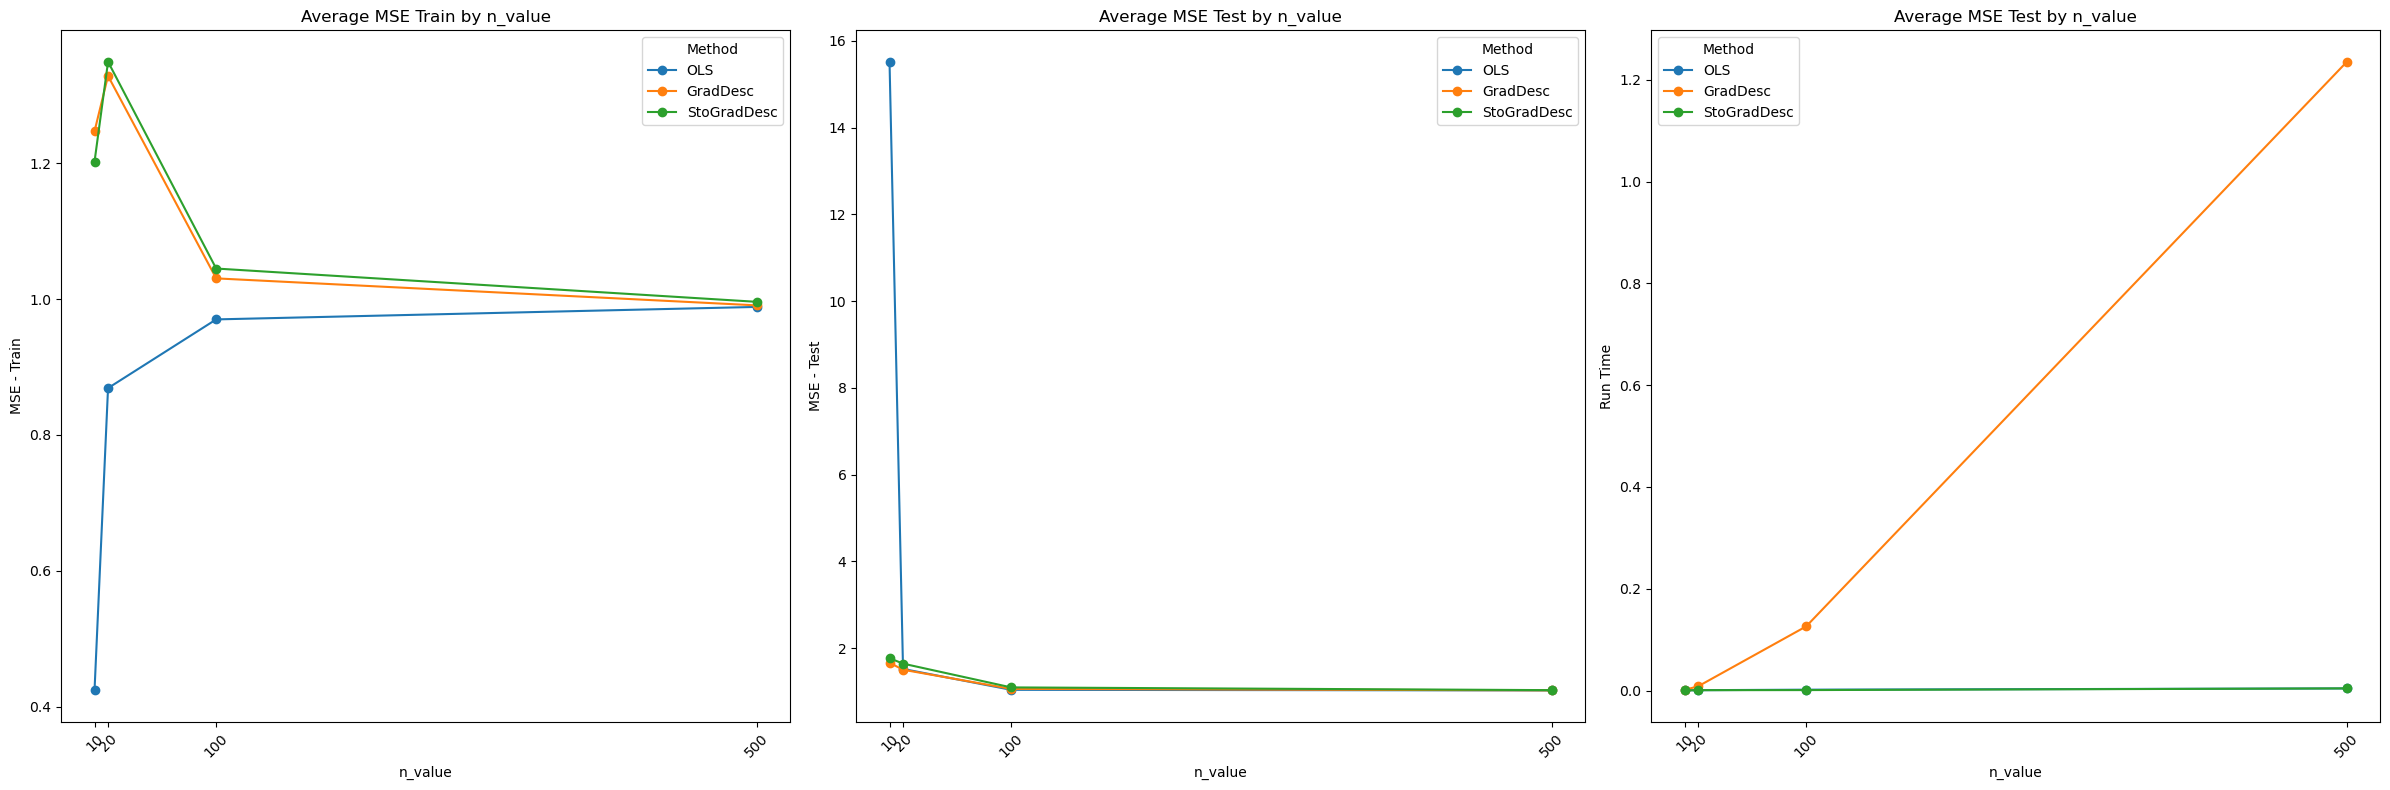

In [31]:
#look at the fixed learning rate results

df = results_fixed.copy()
df = df[df['d_value']<50]
parameter = 'n_value'
method_algorithm = ['OLS','GradDesc','StoGradDesc']

#calculate average metrics for n_values
for col in ['mse_train', 'mse_test', 'run_time']:
    df[col] = df.groupby(by = ['method','n_value'])[col].transform('mean')
df.drop_duplicates(subset = ['method',parameter], inplace = True)

# Creating the plot with adjustments for clear visibility of 'n_value'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
for j, metric in enumerate(['mse_train', 'mse_test', 'run_time']):
    ax = axes[j]
    for method in method_algorithm:
        subset = df[(df['method'] == method)]
        ax.plot(subset[parameter].to_numpy(), subset[metric].to_numpy(), marker='o', linestyle='-', label=method)
    
    if j == 0:
        ax.set_title(f'Average MSE Train by {parameter}')
        ax.set_ylabel('MSE - Train')
        ax.set_xlabel(parameter)
    elif j == 1:
        ax.set_title(f'Average MSE Test by {parameter}')
        ax.set_ylabel('MSE - Test')
        ax.set_xlabel(parameter)
    else:
        ax.set_title(f'Average MSE Test by {parameter}')
        ax.set_ylabel('Run Time')
        ax.set_xlabel(parameter)
    ax.legend(title='Method')
    ax.set_xticks(subset[parameter])
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

When the sample size increases, the MSE 

## Compare method by dimension - fixed learning rate

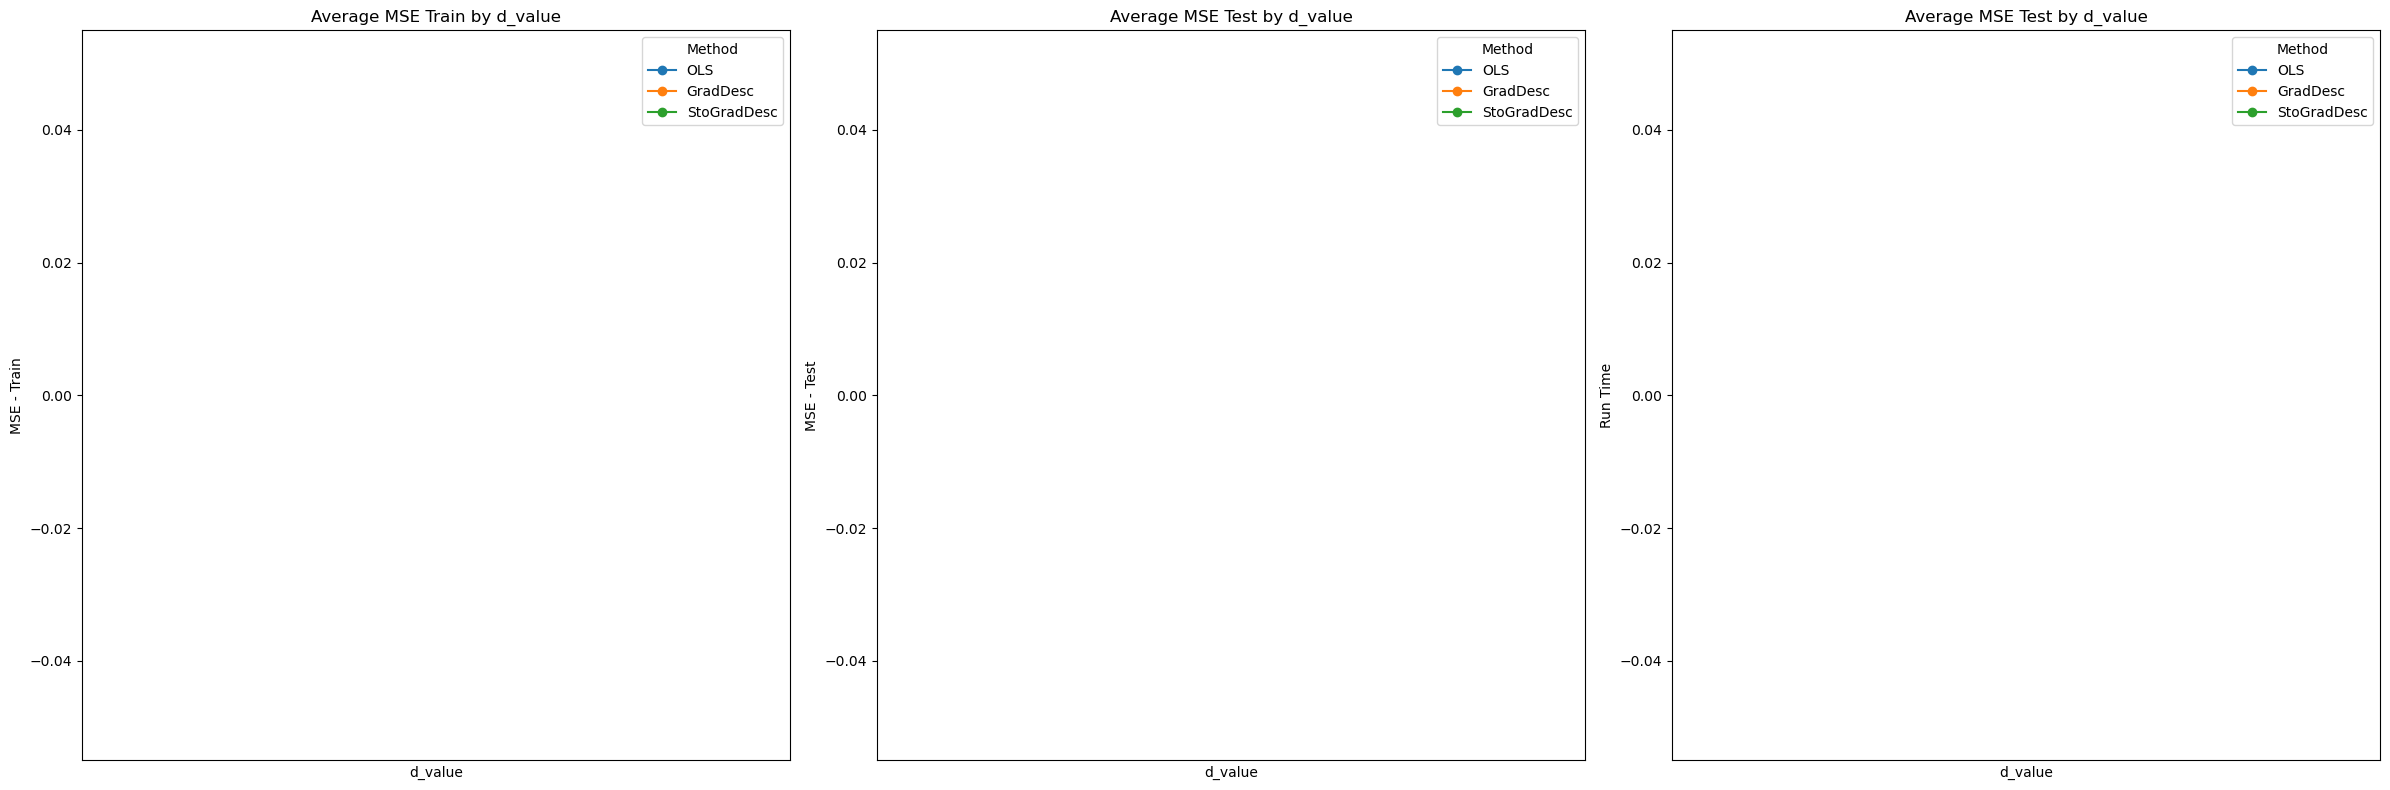

In [25]:
#look at the fixed learning rate results

df = results_fixed.copy()
df = df[df['n_value']>100]
parameter = 'd_value'
method_algorithm = ['OLS','GradDesc','StoGradDesc']

#calculate average metrics for n_values
for col in ['mse_train', 'mse_test', 'run_time']:
    df[col] = df.groupby(by = ['method','n_value'])[col].transform('mean')
df.drop_duplicates(subset = ['method',parameter], inplace = True)

# Creating the plot with adjustments for clear visibility of 'n_value'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
for j, metric in enumerate(['mse_train', 'mse_test', 'run_time']):
    ax = axes[j]
    for method in method_algorithm:
        subset = df[(df['method'] == method)]
        ax.plot(subset[parameter].to_numpy(), subset[metric].to_numpy(), marker='o', linestyle='-', label=method)
    
    if j == 0:
        ax.set_title(f'Average MSE Train by {parameter}')
        ax.set_ylabel('MSE - Train')
        ax.set_xlabel(parameter)
    elif j == 1:
        ax.set_title(f'Average MSE Test by {parameter}')
        ax.set_ylabel('MSE - Test')
        ax.set_xlabel(parameter)
    else:
        ax.set_title(f'Average MSE Test by {parameter}')
        ax.set_ylabel('Run Time')
        ax.set_xlabel(parameter)
    ax.legend(title='Method')
    ax.set_xticks(subset[parameter])
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
#Determine algorithm performance when learning rate is fixed.

results_dynamic = pd.DataFrame()
method_learning_rate = "dynamic"
method_algorithm = ['OLS','GradDesc','StoGradDesc']
# n_values = [10, 20, 100, 500]
# d_values = [2, 5, 10, 50, 100]

n_values = [4, 6, 8, 10]
d_values = [2, 4, 6, 8]

#calculate average of the performance results over 5 runs
number_of_runs = 2
run_number = 0

#running through the n_values and d_values to compare algorithm methods
while run_number < number_of_runs:
    print(run_number)
    for n in n_values:
        for d in d_values:
            arr_train_x, arr_y_train = generate_xy(n, d)
            arr_test_x, arr_y_test = generate_xy(n, d)
            for method in method_algorithm:
                start = time.time()
                if method == 'OLS':
                    w = algorithm_OLS(arr_train_x, arr_y_train)
                elif method == 'GradDesc':
                    w = algorithm_GD(arr_train_x, arr_y_train, method_learning_rate)
                else:
                    w = algorithm_SGD(arr_train_x, arr_y_train, method_learning_rate)
                end = time.time()
                mse_train = mean_square_error(arr_train_x, arr_y_train, w)
                mse_test = mean_square_error(arr_test_x, arr_y_test, w)
                run_time = (end - start)
                line_ = pd.DataFrame([[method, n, d, run_time, mse_train, mse_test]], columns = ['method','n_value','d_value','run_time','mse_train','mse_test'])
                results_dynamic = pd.concat([results_fixed, line_], ignore_index = True)
                results_dynamic.reset_index(drop = True, inplace = True)
    run_number += 1

In [ ]:
#look at the fixed learning rate results

df = results_dynamic.copy()
df = df[df['d_value']<50]
parameter = 'n_value'
method_algorithm = ['OLS','GradDesc','StoGradDesc']

#calculate average metrics for n_values
for col in ['mse_train', 'mse_test', 'run_time']:
    df[col] = df.groupby(by = ['method','n_value'])[col].transform('mean')
df.drop_duplicates(subset = ['method',parameter], inplace = True)

# Creating the plot with adjustments for clear visibility of 'n_value'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
for j, metric in enumerate(['mse_train', 'mse_test', 'run_time']):
    ax = axes[j]
    for method in method_algorithm:
        subset = df[(df['method'] == method)]
        ax.plot(subset[parameter].to_numpy(), subset[metric].to_numpy(), marker='o', linestyle='-', label=method)
    
    if j == 0:
        ax.set_title(f'Average MSE Train by {parameter}')
        ax.set_ylabel('MSE - Train')
        ax.set_xlabel(parameter)
    elif j == 1:
        ax.set_title(f'Average MSE Test by {parameter}')
        ax.set_ylabel('MSE - Test')
        ax.set_xlabel(parameter)
    else:
        ax.set_title(f'Average MSE Test by {parameter}')
        ax.set_ylabel('Run Time')
        ax.set_xlabel(parameter)
    ax.legend(title='Method')
    ax.set_xticks(subset[parameter])
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
#look at the fixed learning rate results

df = results_dynamic.copy()
df = df[df['n_value']>100]
parameter = 'd_value'
method_algorithm = ['OLS','GradDesc','StoGradDesc']

#calculate average metrics for n_values
for col in ['mse_train', 'mse_test', 'run_time']:
    df[col] = df.groupby(by = ['method','n_value'])[col].transform('mean')
df.drop_duplicates(subset = ['method',parameter], inplace = True)

# Creating the plot with adjustments for clear visibility of 'n_value'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
for j, metric in enumerate(['mse_train', 'mse_test', 'run_time']):
    ax = axes[j]
    for method in method_algorithm:
        subset = df[(df['method'] == method)]
        ax.plot(subset[parameter].to_numpy(), subset[metric].to_numpy(), marker='o', linestyle='-', label=method)
    
    if j == 0:
        ax.set_title(f'Average MSE Train by {parameter}')
        ax.set_ylabel('MSE - Train')
        ax.set_xlabel(parameter)
    elif j == 1:
        ax.set_title(f'Average MSE Test by {parameter}')
        ax.set_ylabel('MSE - Test')
        ax.set_xlabel(parameter)
    else:
        ax.set_title(f'Average MSE Test by {parameter}')
        ax.set_ylabel('Run Time')
        ax.set_xlabel(parameter)
    ax.legend(title='Method')
    ax.set_xticks(subset[parameter])
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()